In [ ]:
!pip install spectral seed -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.1/366.1 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import keras
import numpy as np
from keras.layers import* #Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.layers import Conv3D, Input, MaxPooling3D, Dropout, concatenate, UpSampling3D
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import np_utils
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from plotly.offline import init_notebook_mode
import random
from keras import regularizers
import time
from numpy.random import seed
from sklearn import preprocessing
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from keras.utils import to_categorical
from keras.src import backend
from keras.src.layers.merging.base_merge import _Merge
from keras.src.utils import tf_utils
import spectral

init_notebook_mode(connected=True)

In [ ]:
import tensorflow.compat.v2 as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# data loading
dataset = 'IP'
test_ratio = 0.80
windowSize = 16

In [ ]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join('/content/drive/MyDrive/indianpines/Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join('/content/drive/MyDrive/indianpines/Indian_pines_gt.mat'))['indian_pines_gt']

    elif name == 'SA':
        data = sio.loadmat(os.path.join('/content/drive/MyDrive/indianpines/Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join('/content/drive/MyDrive/indianpines/Salinas_gt.mat'))['salinas_gt']

    elif name == 'PU':
        data = sio.loadmat(os.path.join('/content/drive/MyDrive/indianpines/PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join('/content/drive/MyDrive/indianpines/PaviaU_gt.mat'))['paviaU_gt']
    data.shape,labels.shape
    print(data.shape,labels.shape)
    return data, labels
    print(shape, labels)

In [ ]:
# splitting the dataset into train and test
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test
    X.shape, y.shape

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    print(newX.shape)
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX, pca

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=8, removeZeroLabels = True):
    margin = int((windowSize) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin , c - margin:c + margin ]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape

(512, 217, 204) (512, 217)


((512, 217, 204), (512, 217))

In [ ]:
K = X.shape[2]

In [ ]:
K = 16 if dataset == 'IP' else 16
X,pca = applyPCA(X,numComponents=K)
X.shape

(111104, 204)


(512, 217, 16)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)
X.shape, y.shape

((54129, 16, 16, 16), (54129,))



---



---



In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((10825, 16, 16, 16), (43304, 16, 16, 16), (10825,), (43304,))

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(43304, 16, 16, 16, 1)

In [ ]:
Xtest_branch1 = Xtest  # Replace this with the actual data for branch 1
Xtest_branch2 = Xtest  # Replace this with the actual data for branch 2
Xtest_branch3 = Xtest  # Replace this with the actual data for branch 3

ytest_branch = ytest  # Replace this with the actual data for branch 1



---



In [ ]:
Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)
Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

((7217, 16, 16, 16), (3608, 16, 16, 16), (7217,), (3608,))

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(7217, 16, 16, 16, 1)

In [ ]:
# Splitting the input data into three separate branches
Xtrain_branch1 = Xtrain  # Replace this with the actual data for branch 1
Xtrain_branch2 = Xtrain  # Replace this with the actual data for branch 2
Xtrain_branch3 = Xtrain  # Replace this with the actual data for branch 3

Xvalid_branch1 = Xvalid  # Replace this with the actual data for branch 1
Xvalid_branch2 = Xvalid  # Replace this with the actual data for branch 2
Xvalid_branch3 = Xvalid  # Replace this with the actual data for branch 3

# Assuming ytrain and yvalid are your output data
ytrain_output = ytrain  # Replace this with the actual data for output
yvalid_output = yvalid  # Replace this with the actual data for output



---



In [ ]:
# Assuming ytrain and yvalid are your raw labels (not one-hot encoded)
num_classes = 16  # Replace this with the actual number of classes

# One-hot encode the labels
ytrain_output = to_categorical(ytrain_output, num_classes=num_classes)
yvalid_output = to_categorical(yvalid_output, num_classes=num_classes)
ytest_branch = to_categorical(ytest_branch, num_classes=num_classes)

In [ ]:
ytrain_output.shape,  yvalid_output.shape,  ytest_branch.shape

((7217, 16), (3608, 16), (43304, 16))



---



---



In [ ]:
S = windowSize
L = K
input_size =(S,S,L,1)
inputs = Input(input_size)
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [ ]:
def unet(inputs):
    conv1 = Conv3D(64, kernel_size=(3, 3, 3), kernel_regularizer=regularizers.L2(0.001), activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(128, kernel_size=(3, 3, 3), kernel_regularizer=regularizers.L2(0.001), activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False)(conv1)
    conv2 = Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False)(conv2)
    conv3 = Conv3D(256, kernel_size=(3, 3, 3), kernel_regularizer=regularizers.L2(0.001), activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(512, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False)(conv3)
    conv4 = Conv3D(512, kernel_size=(3, 3, 3), kernel_regularizer=regularizers.L2(0.001), activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    up6 = Conv3D(256, (3, 3, 3), kernel_regularizer=regularizers.L2(0.001), activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling3D(size=(2, 2, 2))(conv4))
    merge6 = concatenate([conv3, up6], axis=4)
    conv6 = BatchNormalization()(merge6)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv3D(128, (3, 3, 3), kernel_regularizer=regularizers.L2(0.001), activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling3D(size=(2, 2, 2))(conv6))
    merge7 = concatenate([conv2, up7], axis=4)
    conv7 = BatchNormalization()(merge7)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv3D(64, (3, 3, 3), kernel_regularizer=regularizers.L2(0.001), activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling3D(size=(2, 2, 2))(conv7))
    merge8 = concatenate([conv1, up8], axis=4)
    conv8 = BatchNormalization()(merge8)
    conv8 = Conv3D(64, (3, 3, 3), kernel_regularizer=regularizers.L2(0.001), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    return conv8

def create_multibranch_unet(input_shape=(16, 16, 16, 1), output_units=16):
    input1 = Input(input_shape)
    input2 = Input(input_shape)
    input3 = Input(input_shape)

    # Individual U-Net branches
    branch1_output = unet(input1)
    branch2_output = unet(input2)
    branch3_output = unet(input3)

    # Concatenation of branch outputs
    merged_output = concatenate([branch1_output, branch2_output, branch3_output], axis=-1)

    # Classification layers
    flatten_layer = Flatten()(merged_output)
    dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

    # Model
    model = Model(inputs=[input1, input2, input3], outputs=output_layer)
    adam = Adam(learning_rate=0.001)  # You can adjust the learning rate as needed
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()

    return model


In [ ]:
model = create_multibranch_unet(input_shape=(16, 16, 16, 1), output_units=16)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 16, 16, 16, 1)]      0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 16, 16, 16, 1)]      0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 16, 16, 16, 1)]      0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 16, 16, 16, 64)       1728      ['input_2[0][0]']             
                                                                                              

In [ ]:
filepath = "/content/best-modelsa.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]
print(callbacks_list)

In [ ]:
# Training the model with multiple inputs
history = model.fit(
    x=[Xtrain_branch1, Xtrain_branch2, Xtrain_branch3],
    y=ytrain_output,
    validation_data=([Xvalid_branch1, Xvalid_branch2, Xvalid_branch3], yvalid_output),
    batch_size=128,
    epochs=100,
    callbacks=callbacks_list
)

Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 8.8614 - accuracy: 0.6404
Epoch 1: saving model to /content/best-modelsa.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



57/57 [==============================] - 131s 2s/step - loss: 8.8614 - accuracy: 0.6404 - val_loss: 12.9433 - val_accuracy: 0.2073
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 4.2883 - accuracy: 0.9550
Epoch 2: saving model to /content/best-modelsa.hdf5
57/57 [==============================] - 95s 2s/step - loss: 4.2883 - accuracy: 0.9550 - val_loss: 3.7637 - val_accuracy: 0.8489
Epoch 3/100
57/57 [==============================] - ETA: 0s - loss: 2.8193 - accuracy: 0.9741
Epoch 3: saving model to /content/best-modelsa.hdf5
57/57 [==============================] - 82s 1s/step - loss: 2.8193 - accuracy: 0.9741 - val_loss: 2.3902 - val_accuracy: 0.9670
Epoch 4/100
57/57 [==============================] - ETA: 0s - loss: 2.0200 - accuracy: 0.9794
Epoch 4: saving model to /content/best-modelsa.hdf5
57/57 [==============================] - 90s 2s/step - loss: 2.0200 - accuracy: 0.9794 - val_loss: 1.7175 - val_accuracy: 0.9753
Epoch 5/100
57/57 [======================

**Training graphs**

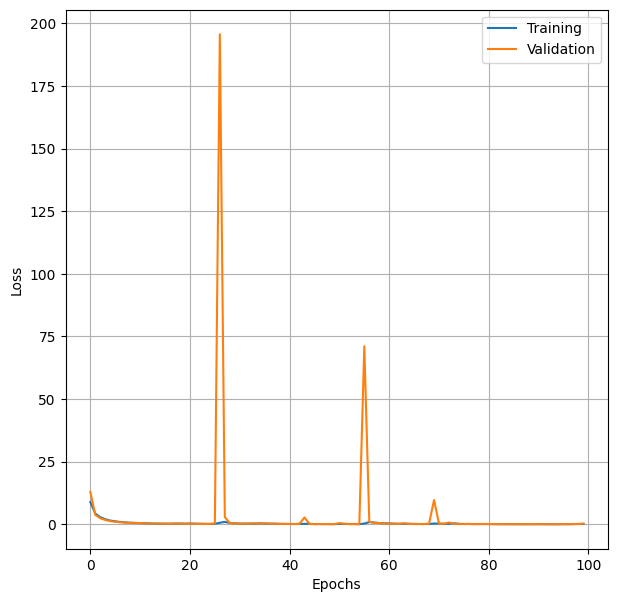

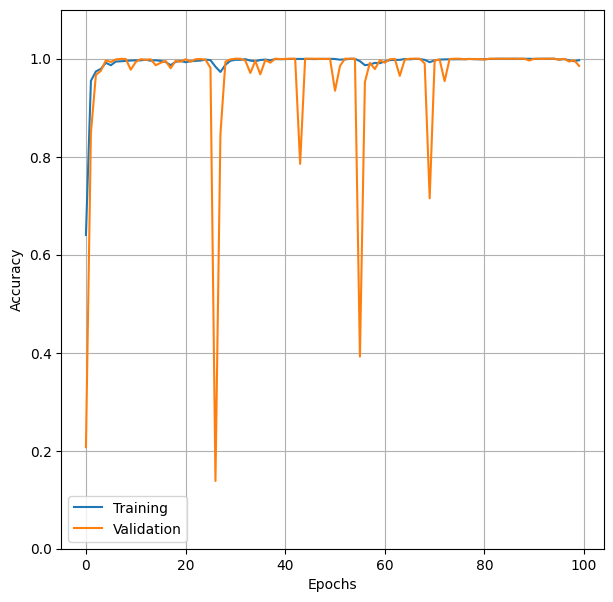

In [ ]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("/content/loss_curve.pdf")
plt.savefig("/content/loss_curve.jpg")
plt.show()
plt.figure(figsize=(7,7))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("/content/acc_curve.pdf")
plt.savefig("/content/acc_curve.jpg")
plt.show()

In [ ]:
# load best weights
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# Assuming Xtest_branch1, Xtest_branch2, and Xtest_branch3 are your input arrays for each branch
Y_pred_test = model.predict([Xtest_branch1, Xtest_branch2, Xtest_branch3])

1354/1354 [==============================] - 142s 103ms/step


In [ ]:
y_pred_test = np.argmax(Y_pred_test, axis=1)
classification = classification_report(np.argmax(ytest_branch, axis=1), y_pred_test, zero_division = 1)
print(classification)

              precision    recall  f1-score   support

           0       1.00      0.95      0.98      1607
           1       1.00      1.00      1.00      2981
           2       0.99      1.00      1.00      1581
           3       0.99      0.99      0.99      1115
           4       1.00      1.00      1.00      2142
           5       1.00      1.00      1.00      3167
           6       1.00      1.00      1.00      2863
           7       0.97      0.99      0.98      9017
           8       1.00      1.00      1.00      4963
           9       0.89      1.00      0.94      2622
          10       1.00      1.00      1.00       854
          11       1.00      0.99      1.00      1542
          12       0.91      0.99      0.95       733
          13       0.94      1.00      0.97       856
          14       1.00      0.93      0.97      5815
          15       1.00      0.89      0.94      1446

    accuracy                           0.98     43304
   macro avg       0.98   

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports(name):
    start = time.time()
    Y_pred = model.predict([Xtest_branch1, Xtest_branch2, Xtest_branch3])
    y_pred = np.argmax(Y_pred, axis=1)
    end = time.time()
    print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(ytest_branch, axis=1), y_pred, target_names=target_names, zero_division = 1)
    oa = accuracy_score(np.argmax(ytest_branch, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(ytest_branch, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(ytest_branch, axis=1), y_pred)
    score = model.evaluate([Xtest_branch1, Xtest_branch2, Xtest_branch3], ytest_branch, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
# Assuming Xtest, ytest, and dataset are your test data and corresponding labels

# Generate classification reports and other metrics using the reports function
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(dataset)

# Print or use the generated metrics and reports
print("Classification Report:\n", classification)
print("Confusion Matrix:\n", confusion)
print("Test Loss:", Test_loss)
print("Test Accuracy:", Test_accuracy)
print("Overall Accuracy (OA):", oa)
print("Each Class Accuracy:", each_acc)
print("Average Accuracy (AA):", aa)
print("Kappa:", kappa)

In [ ]:
classification = str(classification)
confusion = str(confusion)
file_name = "/content/classification_report.txt"


with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize

In [ ]:
K = 16
X,pca = applyPCA(X, numComponents=K)
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict([X_test_image, X_test_image, X_test_image]))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [ ]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)